# Description

Script for doing pose estimation using Intel RealSense D435i, ROS Melodic, OpenCV and ArUco markers

# Imports

In [1]:
import os
import time
import pandas
import numpy
import cv2
from cv_bridge import CvBridge
from cv_bridge.boost.cv_bridge_boost import getCvType

import rospy
from sensor_msgs.msg import Image, CameraInfo
from realsense2_camera.msg import EstimatedPose

# Functions

In [2]:
def create_board(config, marker_index):
    '''Creates a aruco board with the given configuration'''
    return cv2.aruco.GridBoard_create(config["markersX"], config["markersY"], config["markerLength"], config["markerSeparation"], config["dictionary"], marker_index)

def create_boards(config):
    '''Creates all four aruco boards and returns a list of them'''
    boards = []
    marker_index = 0
    board_index = 0
    for board_index in range(4):
        aruco_board = create_board(board_config, marker_index)
        boards.append(aruco_board)
        marker_index += 4
    return boards

def create_charuco_board(config):
    '''Creates a charuco board with the given configuration'''
    return cv2.aruco.CharucoBoard_create(config["squaresX"], config["squaresY"], config["squareLength"], config["markerLength"], config["dictionary"])

def create_charuco_boards(config):
    '''Creates four charuco boards and return a list of them'''
    charuco_boards = []
    board_index = 0
    for board_index in range(4):
        charuco_board = create_charuco_board(config)
        charuco_boards.append(charuco_board)
    return charuco_boards

def detect_marker(cv_image):
    '''Detects aruco marker on the given image'''
    aruco_dictionary = cv2.aruco.Dictionary_get(cv2.aruco.DICT_7X7_50)
    markers, ids, _ = cv2.aruco.detectMarkers(cv_image, aruco_dictionary)
    cv2.aruco.drawDetectedMarkers(cv_image, corners=markers,ids=ids, borderColor=150)
    cv2.imshow("Aruco Window", cv_image)
    return cv_image

def marker_pose_estimation(cv_image):
    '''6DoF Pose estimation of the detected aruco markers'''
    global valid_frames
    global lost_frames
    markers, ids, _ = cv2.aruco.detectMarkers(cv_image, marker_config)
    if ids is not None:
        #if ids.size > 0:
        cv2.aruco.drawDetectedMarkers(cv_image, corners=markers, ids=ids)
        rotation_vector, translation_vector, _ = cv2.aruco.estimatePoseSingleMarkers(markers, 0.02, camera_matrix, distortion_coefficients, None, None)
        for marker in markers:
            cv2.aruco.drawAxis(cv_image, cameraMatrix=camera_matrix, distCoeffs=distortion_coefficients, rvec=rotation_vector, tvec=translation_vector, length=board_config["markerLength"])
            cv2.imshow("Markery", cv_image)
            out.write(cv_image)
            valid_frames += 1
            return translation_vector, rotation_vector
    else:        
        cv2.imshow("Marker", cv_image)
        out.write(cv_image)
        lost_frames += 1
        return numpy.array([float('NaN'), float('NaN'), float('NaN')]),numpy.array([float('NaN'), float('NaN'), float('NaN')])

def board_pose_estimation(cv_image):
    '''Does Board pose estimation'''
    global valid_frames
    global lost_frames
    markers, ids, _ = cv2.aruco.detectMarkers(cv_image, board_config["dictionary"])
    if ids is not None:
    #if ids.size > 0:
        cv2.aruco.drawDetectedMarkers(cv_image, corners=markers, ids=ids)
        valid, rotation_vector, translation_vector = cv2.aruco.estimatePoseBoard(markers, ids, boards[0], camera_matrix, distortion_coefficients, None, None)
        #if valid > 0:
        cv2.aruco.drawAxis(cv_image, camera_matrix, distortion_coefficients, rotation_vector, translation_vector, 0.03)
        cv2.imshow("Board", cv_image)
        out.write(cv_image)
        valid_frames += 1
        return translation_vector, rotation_vector
    else:
        cv2.imshow("Board", cv_image)
        out.write(cv_image)
        lost_frames += 1
        return numpy.array([float('NaN'), float('NaN'), float('NaN')]),numpy.array([float('NaN'), float('NaN'), float('NaN')])

def charuco_pose_estimation(cv_image):
    '''Does poes estimation using the charuco board (chessboard + aruco marker) in the given configuration'''
    global valid_frames
    global lost_frames
    global prev_tvec
    global prev_rvec
    corners, ids, _ = cv2.aruco.detectMarkers(cv_image, charuco_config["dictionary"], parameters=params)
    if ids is not None:
        charuco_retval, charuco_corners, charuco_ids = cv2.aruco.interpolateCornersCharuco(corners, ids, cv_image, charuco_boards[0], minMarkers=1)
        cv2.aruco.drawDetectedCornersCharuco(cv_image, charuco_corners, charuco_ids)
        retval, rotation_vector, translation_vector = cv2.aruco.estimatePoseCharucoBoard(charuco_corners, charuco_ids, charuco_boards[0],camera_matrix, distortion_coefficients, None, None)# rotation_vector, translation_vector)
        if retval == True:
            cv2.aruco.drawAxis(cv_image, camera_matrix, distortion_coefficients, rotation_vector, translation_vector, 0.03 )
            cv2.imshow("Charuco", cv_image)
            out.write(cv_image)
            valid_frames += 1
            prev_tvec = translation_vector
            prev_rvec = rotation_vector
            return translation_vector, rotation_vector
        else: 
            cv2.imshow("Charuco", cv_image)
            out.write(cv_image)
            lost_frames += 1
            return prev_tvec, prev_rvec
            #return numpy.array([float('NaN'), float('NaN'), float('NaN')]),numpy.array([float('NaN'), float('NaN'), float('NaN')])
    else:
        cv2.imshow("Charuco", cv_image)
        out.write(cv_image)
        lost_frames += 1
        return prev_tvec, prev_rvec
        #return numpy.array([float('NaN'), float('NaN'), float('NaN')]),numpy.array([float('NaN'), float('NaN'), float('NaN')])
    
def image_callback(ros_image):
    '''Callback function for the subscription of the ROS topic /camera/color/image_raw (sensor_msgs Image)'''
    global bridge
    global pose
    cv_image = bridge.imgmsg_to_cv2(ros_image, "bgr8")
    #tvec, rvec = marker_pose_estimation(cv_image)
    #tvec, rvec = board_pose_estimation(cv_image)
    tvec, rvec = charuco_pose_estimation(cv_image)
    tvec_filter, rvec_filter = filter_pose(tvec, rvec)
    #tvec += marker_offset
    pose = numpy.concatenate([tvec_filter, rvec_filter]).reshape(6,)
    #publish_pose(tvec, rvec)
    cv2.waitKey(1)
    
def calibration_callback(data):
    '''Sets the calibration parameters - camera_matrix and distortion_coefficients - by reading ROS topic /camera/color/cameraInfo'''
    global camera_matrix
    global distortion_coefficients
    camera_matrix = numpy.array(data.K).reshape(3,3)
    distortion_coefficients = numpy.array(data.D).reshape(5,)
    
def run_ros_node():
    '''Initializes the ROS node and setting up Subscriptions and Publishers'''
    rospy.init_node("aruco_estimater", anonymous=True)
    rospy.Subscriber("/camera/color/image_raw", Image, image_callback)
    rospy.Subscriber("/camera/color/camera_info", CameraInfo, calibration_callback)
    
def filter_pose(tvec, rvec):
        '''Running Mean Filter for estimated pose'''
        tvec_raw = [tx_raws, ty_raws, tz_raws]
        rvec_raw = [rx_raws, ry_raws, rz_raws]
        i = 0
        j = 0 

        for t in tvec_raw:
            t.append(tvec[i])
            t.pop(0)
            tvec_filtered[i] = numpy.mean(t)
            i += 1
        for r in rvec_raw:
            r.append(rvec[j])
            r.pop(0)
            rvec_filtered[j] = numpy.mean(r)
            j += 1
        return tvec_filtered, rvec_filtered

# Configuration | Instantiation

In [3]:
CWD = os.getcwd()
#marker_type = "marker"
#marker_type = "board"
#marker_type = "charuco"
marker_type = "charuco_3344_5_filtered_prev"
#marker_type = "charuco_3377"
#run_type = "static"
#run_type = "dyn20"
run_type = "dyn60"
#run_type = "dyn100"
#run_type = "test"

bridge = CvBridge()
pose_publisher = rospy.Publisher("/pose_estimation1", EstimatedPose, queue_size=1)

out = cv2.VideoWriter(os.path.join(*[CWD,"200727_{}_{}.avi".format(marker_type, run_type)]), cv2.VideoWriter_fourcc("M", "P", "E", "G"), 30, (640,480))

marker_config = cv2.aruco.Dictionary_get(cv2.aruco.DICT_7X7_50)

board_config = {
    "markersX" : 2,
    "markersY" : 2,
    "markerLength" : 0.02,
    "markerSeparation" : 0.005,
    "dictionary" : cv2.aruco.Dictionary_get(cv2.aruco.DICT_7X7_50)
}

charuco_config_1 = {
    "squaresX" : 5,
    "squaresY" : 5,
    "squareLength" : 0.0115,
    "markerLength" : 0.008,
    "dictionary" : cv2.aruco.Dictionary_get(cv2.aruco.DICT_7X7_50)
}
charuco_config = {
    "squaresX" : 3,
    "squaresY" : 3,
    "squareLength" : 0.018,
    "markerLength" : 0.014,
    "dictionary" : cv2.aruco.Dictionary_get(cv2.aruco.DICT_4X4_50)
}
charuco_config_2 = {
    "squaresX" : 3,
    "squaresY" : 3,
    "squareLength" : 0.018,
    "markerLength" : 0.014,
    "dictionary" : cv2.aruco.Dictionary_get(cv2.aruco.DICT_7X7_50)
}

boards = create_boards(board_config)
charuco_boards = create_charuco_boards(charuco_config)

marker_offset = numpy.array([-0.03, -0.03, 0])

params = cv2.aruco.DetectorParameters_create()
# P: Projection Camera Matrix (4x3)
# K: Intrinsic Camera Matrix for (distorted) raw images (3x3)
# R: Rectification Matrix (3x3)
# D: Distortion Parameters (5x1)

N = 5
tx_raws = list(numpy.zeros(N))
ty_raws = list(numpy.zeros(N))
tz_raws = list(numpy.zeros(N))
rx_raws = list(numpy.zeros(N))
ry_raws = list(numpy.zeros(N))
rz_raws = list(numpy.zeros(N))

tvec_filtered = numpy.zeros((3,1))
rvec_filtered = numpy.zeros((3,1))

prev_tvec = numpy.zeros((3,1))
prev_rvec = numpy.zeros((3,1))

# Main

In [4]:
valid_frames = 0
lost_frames = 0
run_ros_node()
rate = rospy.Rate(30)
poses = []
frames = []
time.sleep(1)
valid_frames = 0
lost_frames = 0

for i in range(30*30):
    poses.append(pose)    
    rate.sleep()
    
poses_df = pandas.DataFrame(poses, columns=["tx", "ty", "tz", "rx", "ry", "rz"])
frames_df = pandas.DataFrame(numpy.array([valid_frames, lost_frames]).reshape(1,2), columns=["valid", "lost"])
out.release()
cv2.destroyAllWindows()

/home/lars/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


In [5]:
frames_df

,valid,lost
0,892,4


# Save

In [6]:
poses_df.to_feather(os.path.join(*[CWD,'poses_{}_{}.ftr'.format(marker_type, run_type)]))
frames_df.to_feather(os.path.join(*[CWD, 'frames_{}_{}.ftr'.format(marker_type, run_type)]))

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f39c5fd6978>,
      dtype=object)

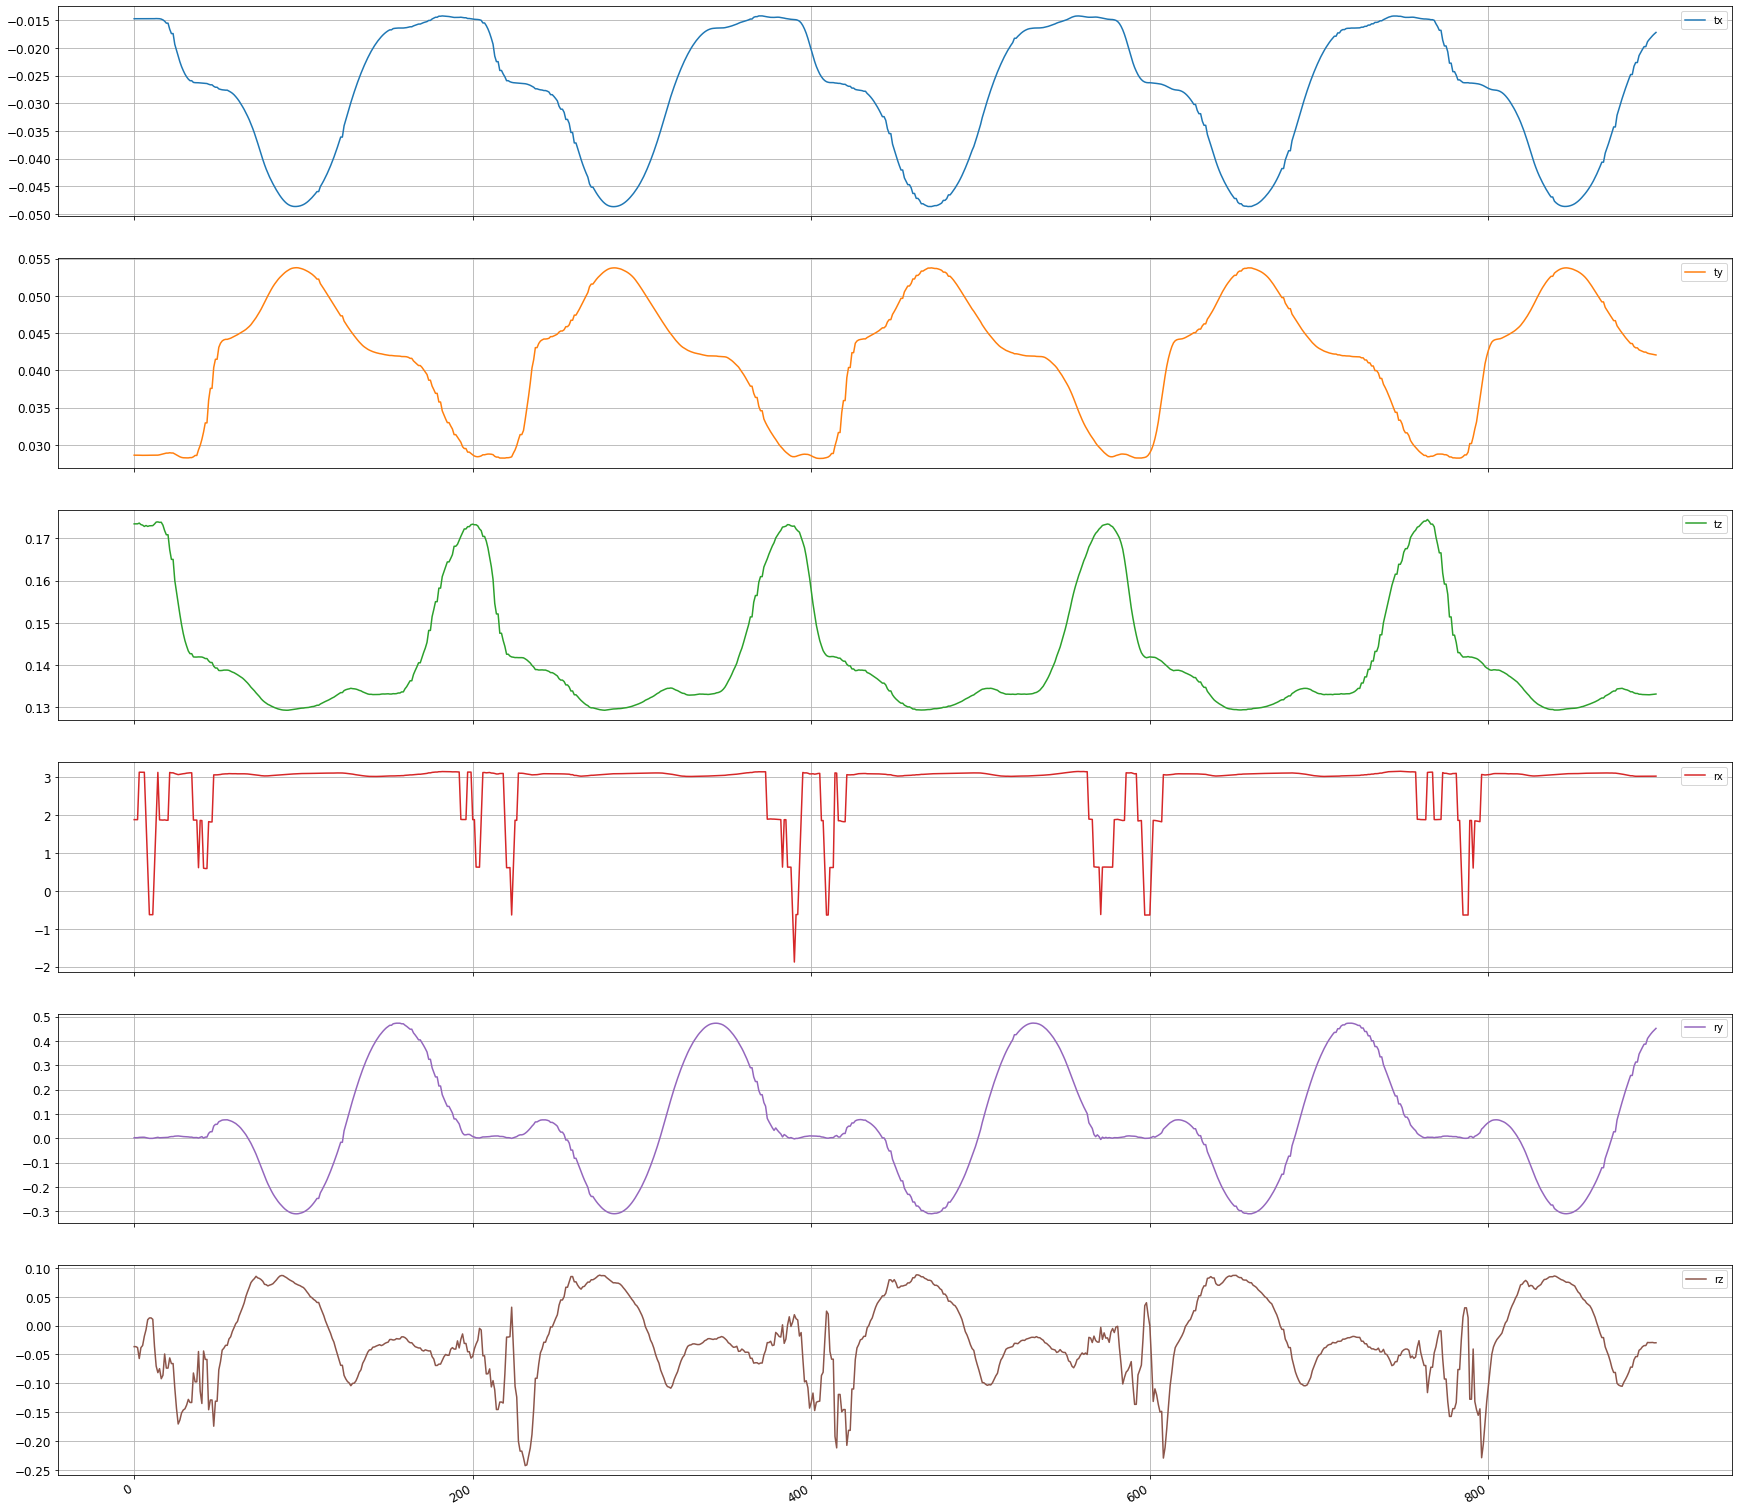

In [7]:
poses_df.plot(subplots=True, figsize=(30,30), grid=True, legend=True, fontsize=12)

In [ ]:
posed_df.